* Preprocessing



* **Feature Analysis**



* Filling missing values



* **Feature Engineering**



* **Modeling**

    * Simple
    
    * Ensemble
    
    
* Prediction and result submission

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold,learning_curve

sns.set(style='white',context='notebook',palette='deep')

### Loading and checking data

In [2]:
ls

 Volume in drive C is OS
 Volume Serial Number is C4F3-58A4

 Directory of C:\Users\ASUS\Desktop\Titanic

13-05-2020  11:37    <DIR>          .
13-05-2020  11:37    <DIR>          ..
13-05-2020  11:37    <DIR>          .ipynb_checkpoints
13-05-2020  11:34             3,258 gender_submission.csv
13-05-2020  11:36             3,258 Null_Accuracy_Submission_1.csv
13-05-2020  11:37             3,258 Null_Accuracy_Submission_2.csv
13-05-2020  11:33            28,629 test.csv
13-05-2020  11:32           493,929 Titanic-Submission#2.ipynb
13-05-2020  11:37            64,836 Titanic-Submission.ipynb
13-05-2020  11:34            61,194 train.csv
               7 File(s)        658,362 bytes
               3 Dir(s)  21,217,521,664 bytes free


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
IDtest = test['PassengerId']

### Outlier Detection - Tukey Method

In [4]:
## Function will use Tukey method to compute outliers by taking a dataframe and return a list of indices 
## corresponding to observations which contain more than n outliers

def detect_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over dataframe
    for col in features:
        # Find 1st Quartile
        Q1 = np.percentile(df[col],25)
        # Find 3rd Quartile
        Q3 = np.percentile(df[col],75)
        # Find Interquartile Range
        IQR = Q3 - Q1
        
        # setting outlier_step to 1.5
        outlier_step = 1.5 * IQR
        
        # Determine a lot of indices of outliers for feature column
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step) ].index
        
        # appending indices 
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    
    multiple_outliers = list( k for k,v in outlier_indices.items() if v > n)
    
    return multiple_outliers

# detecting outliers in titanic dataset for SibSp, Age, Parch and Fare features
outliers_to_drop = detect_outliers(train,2,['SibSp', 'Age', 'Parch', 'Fare'])

In [5]:
outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [6]:
train.loc[outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


#### We can see that the above records have high number of SibSp so dropping these rows

In [8]:
train = train.drop(outliers_to_drop,axis=0).reset_index(drop=True)

#### Joining the training and test dataset in order to obtain the same number of features during categorical conversion

In [10]:
train_len = len(train)
df = pd.concat(objs=[train,test],axis=0).reset_index(drop=True)

#### Checking for missing values

In [11]:
# Fill empty values with NaN

df.fillna(np.nan, inplace=True)

# Checking for null values
df.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            254
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          997
Embarked         2
dtype: int64

#### Survived column has null values because we concatenated the test dataset with it

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  871 non-null    int64  
 1   Survived     871 non-null    int64  
 2   Pclass       871 non-null    int64  
 3   Name         871 non-null    object 
 4   Sex          871 non-null    object 
 5   Age          703 non-null    float64
 6   SibSp        871 non-null    int64  
 7   Parch        871 non-null    int64  
 8   Ticket       871 non-null    object 
 9   Fare         871 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     869 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 81.8+ KB


In [13]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            168
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          670
Embarked         2
dtype: int64

In [14]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Feature Analysis

### Analyzing Numerical Values

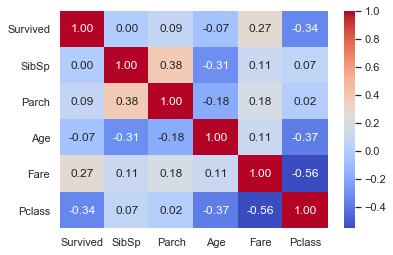

In [19]:
# Correlation between numerical values 
g = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare','Pclass']].corr(),annot=True,fmt='.2f',cmap='coolwarm')

**1. Fare is having correlation with Survived.**


**2. Pclass is having correlation w Survived and Fare. Need to look out for multicollinearity.**


It doesn't mean all other features are not useful. We need to look at subsamples.

#### SibSp

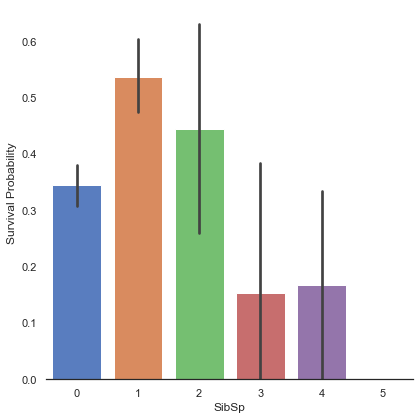

In [24]:
## Explore SibSp feature vs Survived

g = sns.catplot(x='SibSp',y='Survived',data=train,kind='bar',height=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

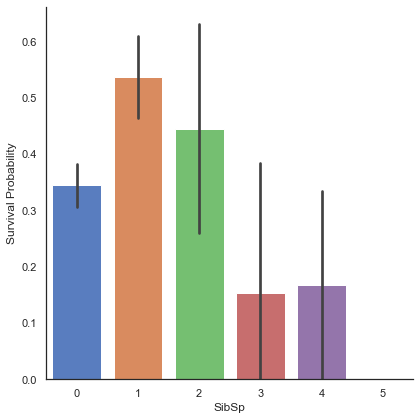

In [25]:
## Explore SibSp feature vs Survived

g = sns.catplot(x='SibSp',y='Survived',data=train,kind='bar',height=6,palette='muted')
g.despine(left=False)
g = g.set_ylabels('Survival Probability')

It seems that passengers that had higher number of siblings/spouses have less chance to survive.

Single passengers i.e. 0 SibSp or with 2 other passengers SibSp = 1 or 2 have more chance to survive.

This is quite interesting observation. 

#### Parch

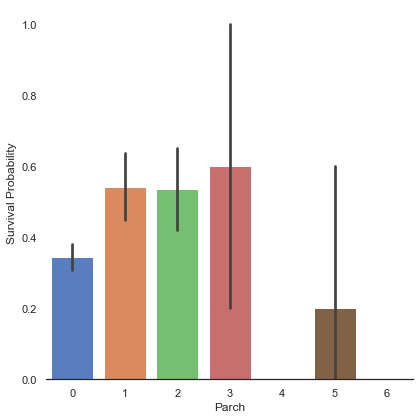

In [27]:
## Explore Parch feature vs Survived

g = sns.catplot(x='Parch',y='Survived',data=train,kind='bar',height=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

* Small Families have higher chance to survive.


* Survival rate for Small families is more than single (Parch=0), medium (Parch=3,4) and large families (Parch=5,6)

#### Age

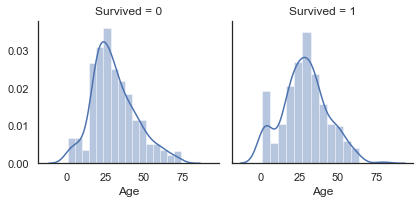

In [28]:
## Explore Age vs Survived

g = sns.FacetGrid(train,col='Survived')
g = g.map(sns.distplot,'Age')

#### Age distribution seems to be of gaussian nature.

* The age distribution is not similar in Survived and Not Survived subpopulations. 


* There is a peak corresponding to young passengers that have survived. Higher age groups are having lesser rate.


* So we can see even if Age is not that correlated to Survived (corr = -0.08), there are categories that have more or less chance to survive.

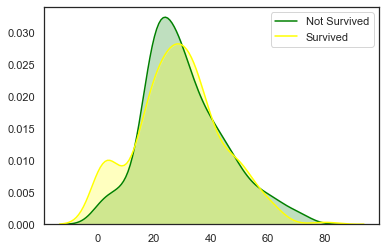

In [30]:
# Explore Age Distributions

g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())],color='Green',shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())],color='Yellow',shade=True,ax=g)
g = g.legend(['Not Survived','Survived'])

When we superimpose the two density graphs, there is a peak corresponding to 0 and 5, which are babies or very young children.

#### Fare

In [31]:
df['Fare'].isnull().sum()

1

In [32]:
# Filling the Fare missing value with median value, since we've just 1 missing value

df['Fare'].fillna(df['Fare'].median(),inplace=True)

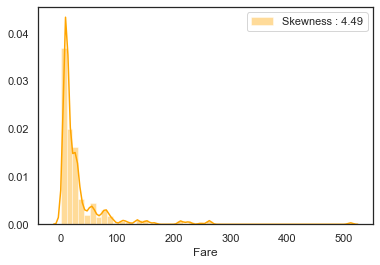

In [39]:
# Exploring Fare distribution

g = sns.distplot(df['Fare'],color='orange',label='Skewness : %.2f'%(df['Fare'].skew()))
g = g.legend(loc='best')

We can see that Fare distribution is very skewed and it can lead to overweight of very high values in the model even if it is scaled.

So let's take a log transform to reduce this skew.

In [40]:
df['Fare'] = df['Fare'].map(lambda x : np.log(x) if x > 0 else 0)

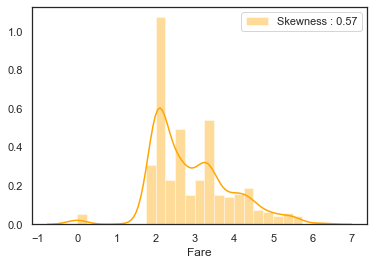

In [41]:

g = sns.distplot(df['Fare'],color='orange',label='Skewness : %.2f'%(df['Fare'].skew()))
g = g.legend(loc='best')

We can see that the skewness has reduced quite a bit.

### Analysing Categorical Values

#### Sex

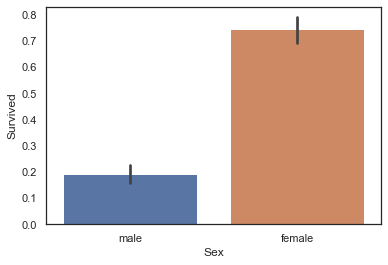

In [42]:
g = sns.barplot(x='Sex',y='Survived',data=train)

In [43]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.744262
male,0.190813


It's clearly obvious that Male have lesser chance to survive vis a vis female.

'Women and Children First'

#### Pclass

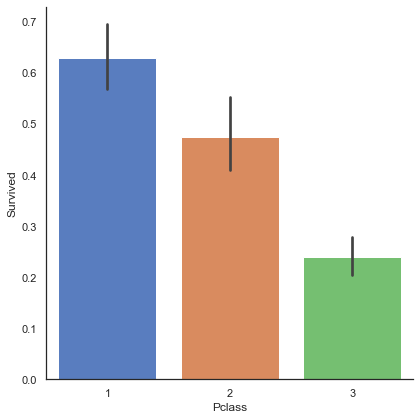

In [45]:
# Explore Pclass vs Survived

g = sns.catplot(x='Pclass',y='Survived',data=train,kind='bar',height=6,palette='muted')

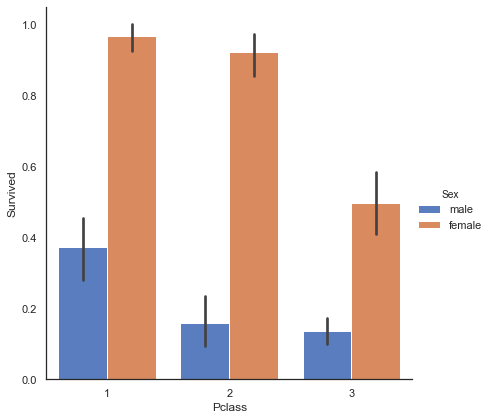

In [46]:
# Explore Pclass vs Survived by Sex

g = sns.catplot(x='Pclass',y='Survived',data=train,kind='bar',height=6,palette='muted',hue='Sex')

The passenger survival is not same in all the 3 classes. FIrst class passengers are more likely to surive than second class and third class passengers.

Trend b/w male and female passengers remains the same across classes but the first class male survival rate seems to be a tad little higher than the other 2 classes.

#### Embarked

In [47]:
df['Embarked'].isnull().sum()

2

In [48]:
df['Embarked'].value_counts()

S    896
C    270
Q    121
Name: Embarked, dtype: int64

Since there are only 2 missing values we'll fill the most frequent value of Embarked which is S

In [49]:
df['Embarked'].fillna('S',inplace=True)

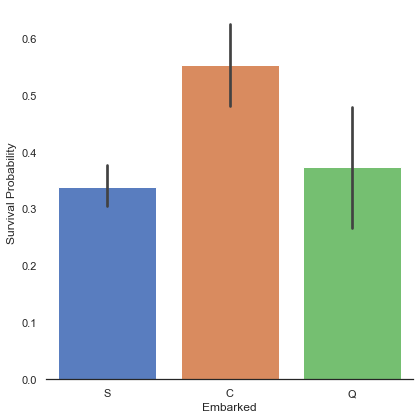

In [50]:
# Explore Embarked vs Survived

g = sns.catplot(x='Embarked',y='Survived',data=train,height=6,kind='bar',palette='muted')
g.despine(left=True)
g=g.set_ylabels("Survival Probability")

It seems that passengers who embarked from C - Cherbourg have more chance to survive.

We can distantly assume (hypothesize) that proportion of first class passengers is higher for those who came from Cherbourg (C) than from Q or S

* C - Cherbourg
* Q - Queenstown
* S - Southampton

Let's see the Pclass distribution vs Embarked

### Offtopic

Controlling Figure Aesthetics with Seaborn : https://seaborn.pydata.org/tutorial/aesthetics.html

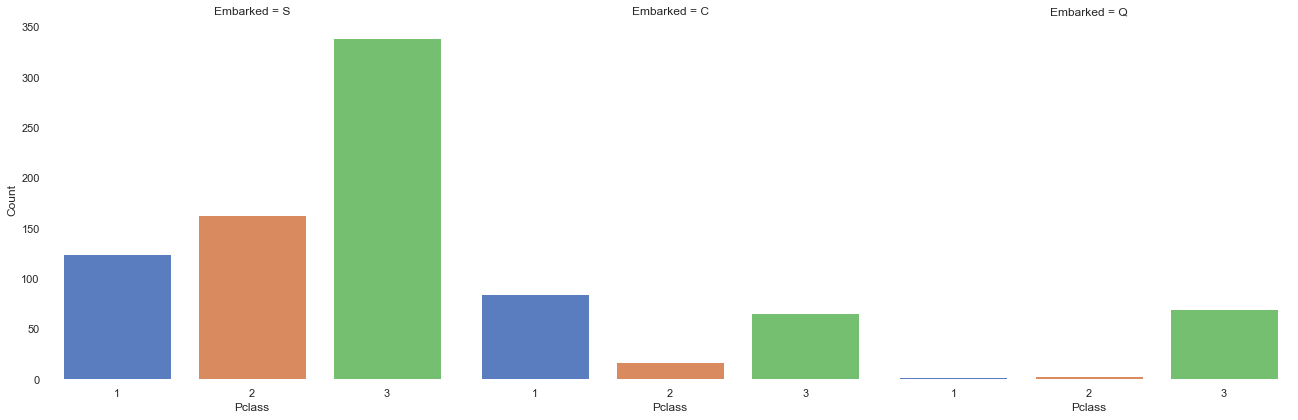

In [51]:
# Exploring Pclass vs Embarked

g = sns.catplot('Pclass',col='Embarked',data=train,height=6,kind='count',palette='muted')
g.despine(left=True,bottom=True)
g=g.set_ylabels("Count")

Indeed, the third class is most frequent for passengers coming in from Southampton (S) and Queenstown (Q), where as the passengers embarking from Cherbourg (C) having Pclass = 1 is much higher.

* Why PClass = 1 survived more? 


+ Maybe the people who have first class were priortized during evacuation, or maybe they were occupying upper decks of the ship due to which they were able to come to the rescue points much earlier than the second and third class.

### Fill Missing Values

In [52]:
df.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            254
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          997
Embarked         0
dtype: int64

#### 1. Age

Age column contains 256 missing values in the whole dataset.

Since there is subpopulations that have more chance to survive (like Children), it is preferable to keep the age feature to impute the missing values.

To address this problem, let's look at the most correlated features with Age


* Parch
* SibSp
* Pclass
* Sex

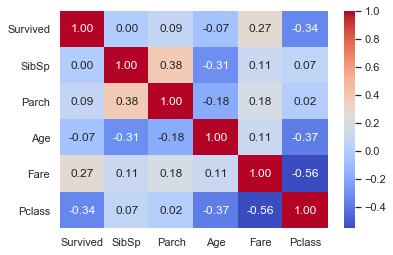

In [53]:
# Correlation between numerical values 
g = sns.heatmap(train[['Sex','Survived','SibSp','Parch','Age','Fare','Pclass']].corr(),annot=True,fmt='.2f',cmap='coolwarm')

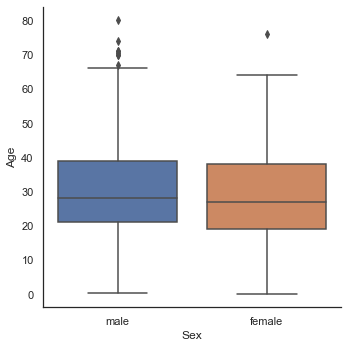

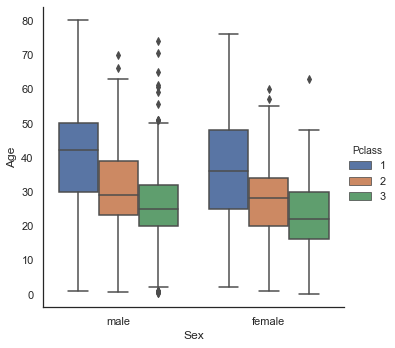

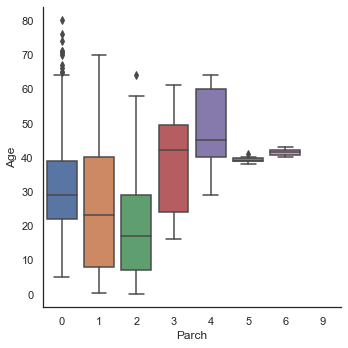

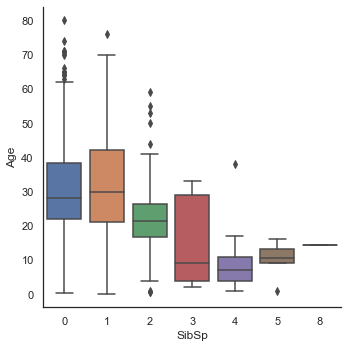

In [54]:
g = sns.catplot(y='Age',x='Sex',data=df,kind='box')

g = sns.catplot(y='Age',x='Sex',hue='Pclass',data=df,kind='box')

g = sns.catplot(y='Age',x='Parch',data=df,kind='box')

g = sns.catplot(y='Age',x='SibSp',data=df,kind='box')

* Age distribution seems to be same in Male and Female subpopulations.


* So, we can infer that Sex is not informative to predict Age


* First class passengers are older than second class passengers who are also older than Third class passengers.


* More a passenger has parent/children (Parch) the older he is.


* More a passenger has siblings/spouses (SibSp) the younger he is.

In [55]:
# convert sex into a categorical value

df['Sex'] = df['Sex'].map({'male':0,'female':1})

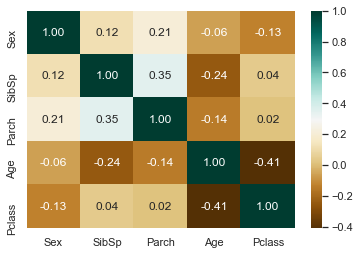

In [56]:
g = sns.heatmap(df[['Sex','SibSp','Parch','Age','Pclass']].corr(),annot=True,fmt='.2f',cmap='BrBG')

Correlation map confirms the factorplots observations except for Parch. Age is not correlated w Sex, but is negatively correlated with Pclass, Parch and SibSp.

In boxplot of Age as a function of Parch, age is growing with number of parents / children. But the general correlation is negative.

So we've decided to use SibSp, Parch, Pclass in order to impute missing values in age.

Strategy is to fill Age with the median age of similar rows according to Pclass, Parch, and SibSp.

In [57]:
# Filling missing values of age

# Fill Age with median age of similar rows accoring to Pclass, Parch and SibSp

index_nan = list(df['Age'][df['Age'].isnull()].index)

for i in index_nan:
    age_median = df['Age'].median()
    age_pred = df['Age'][((df['SibSp'] == df.iloc[i]['SibSp']) & (df['Parch'] == df.iloc[i]['Parch']) & 
                          (df['Pclass'] == df.iloc[i]['Pclass']))].median()
    
    if not np.isnan(age_pred):
        df['Age'].iloc[i] = age_pred
    else:
        df['Age'].iloc[i] = age_median

C:\Users\ASUS\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Homework

In [58]:
df['Age'][((df['SibSp'] == df.iloc[i]['SibSp']) & (df['Parch'] == df.iloc[i]['Parch']) & 
                          (df['Pclass'] == df.iloc[i]['Pclass']))].median()

16.5

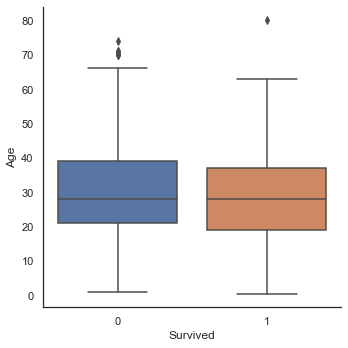

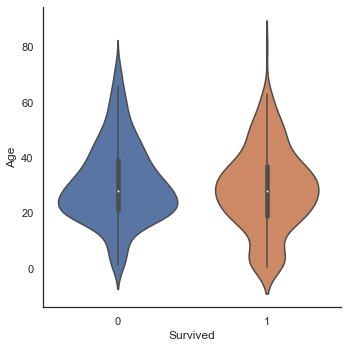

In [59]:
g = sns.catplot(x='Survived',y='Age',data=train,kind='box')
g = sns.catplot(x='Survived',y='Age',data=train,kind='violin')

No difference in the median value of age in survived and not survived population.

but in violin plot we can see that very young passengers have higher survival rate.

### Feature Engineering

#### Name/Title

In [60]:
df['Name'].head(30)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

Name feature contains passenger title.

Since some passengers are having distinguished titles, their evacuation chances would be higher as compared to the other passengers.

In [61]:
# Getting titles from name

#df['Name'][0].split(',')[1].split('.')[0].strip()


df_title = [i.split(',')[1].split('.')[0].strip() for i in df['Name']]
df['Title']=pd.Series(df_title)
df['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

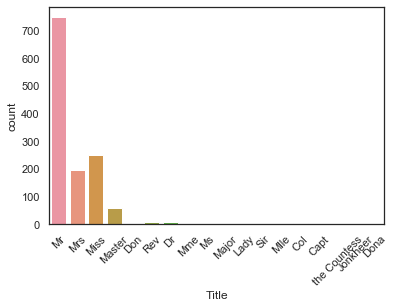

In [62]:
g = sns.countplot(x='Title',data=df)
g = plt.setp(g.get_xticklabels(),rotation=45)

In [63]:
df['Title'].value_counts()

Mr              748
Miss            252
Mrs             196
Master           59
Dr                8
Rev               8
Col               4
Major             2
Ms                2
Mlle              2
Jonkheer          1
Don               1
Mme               1
Dona              1
Lady              1
the Countess      1
Sir               1
Capt              1
Name: Title, dtype: int64

In [64]:
df['Title'].value_counts()

Mr              748
Miss            252
Mrs             196
Master           59
Dr                8
Rev               8
Col               4
Major             2
Ms                2
Mlle              2
Jonkheer          1
Don               1
Mme               1
Dona              1
Lady              1
the Countess      1
Sir               1
Capt              1
Name: Title, dtype: int64

In [65]:
df['Title'] = df['Title'].replace(['Lady','Jonkheer','the Countess','Major',
                                  'Ms','Mlle','Col','Rev','Dr','Sir','Mme','Dona'
                                 ,'Don','Capt'],'Rare')

# Convert Title into a categorical variable

df['Title'] = df['Title'].map({'Mr':0,'Miss':1,'Mrs':1,'Master':2,'Rare':3})

df['Title'] = df['Title'].astype(int)

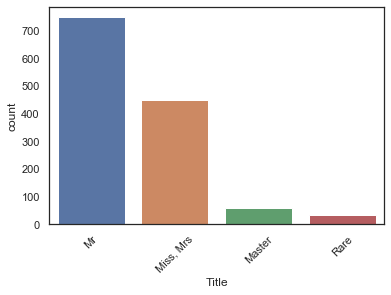

In [66]:
g = sns.countplot(x='Title',data=df)
g = plt.setp(g.set_xticklabels(['Mr','Miss, Mrs','Master','Rare']),rotation=45)

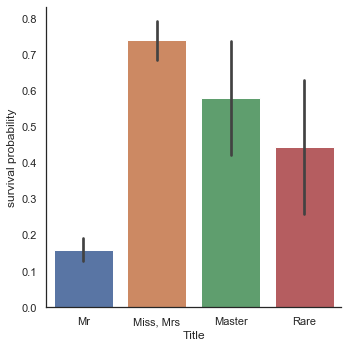

In [68]:
g = sns.catplot(x='Title',y='Survived',data=df,kind='bar')
g = g.set_xticklabels(['Mr','Miss, Mrs','Master','Rare'])
g = g.set_ylabels('survival probability')

'Women and children first'

Survival Probability Order :


Miss/Mrs > Master > Rare > Mr

In [69]:
df.drop(['Name'],axis=1,inplace=True)

### Family Size

Larger families will have more difficulty in evacuation since they might have been looking for each other during the chaos.

We'll create a single feature Fsize = SibSp + Parch + 1

In [70]:
df['Fsize'] = df['SibSp'] + df['Parch'] + 1

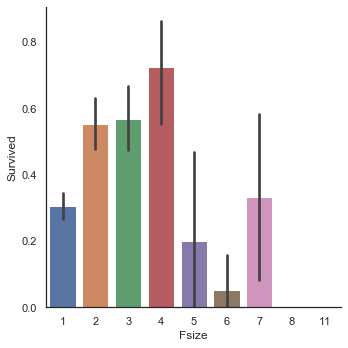

In [71]:
g = sns.catplot(x='Fsize',y='Survived',data=df,kind='bar')



Family size seems to play an important role, survival prob. is lower for large families.

In [72]:
df['Single'] = df['Fsize'].map(lambda s:1 if s==1 else 0)
df['SmallF'] = df['Fsize'].map(lambda s:1 if s==2 else 0)
df['MediumF'] = df['Fsize'].map(lambda s:1 if 3 <= s <= 4 else 0)
df['LargeF'] = df['Fsize'].map(lambda s:1 if s > 4 else 0)

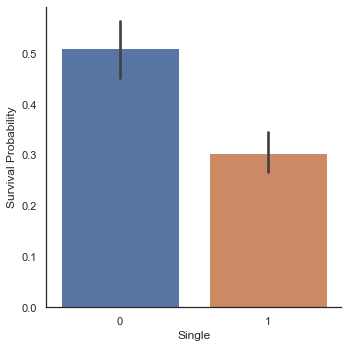

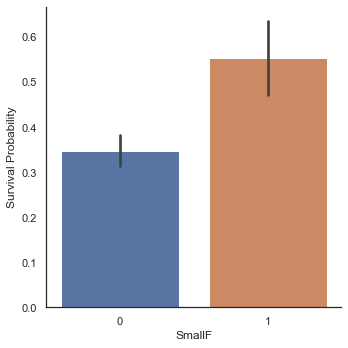

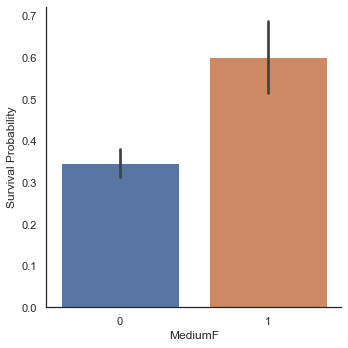

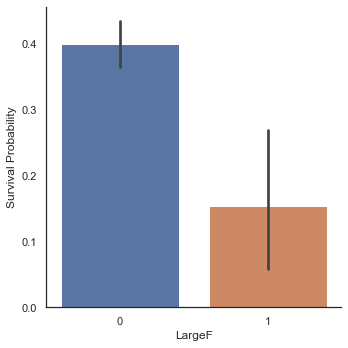

In [73]:
g = sns.catplot(x='Single',y='Survived',data=df,kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x='SmallF',y='Survived',data=df,kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x='MediumF',y='Survived',data=df,kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x='LargeF',y='Survived',data=df,kind='bar')
g = g.set_ylabels('Survival Probability')



Factorplots of family size show that Small and Medium familites have more chance to survive than single passenger and large families

In [74]:
# convert to indicator values Title and Embarked

df = pd.get_dummies(df,columns=['Title'])
df = pd.get_dummies(df,columns=['Embarked'],prefix='Em')

In [75]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MediumF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,1,0,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,1,0,0,0,0,0,1


#### At this stage we've 22 features now

#### Cabin

In [76]:
df['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [77]:
df['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [78]:
df['Cabin'].isnull().sum()

997

* Cabin feature column has 292 values


* Out of 292 there are 186 unique values


* There are 1007 missing values

In [79]:
df['Cabin'][df['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [80]:
# Replace the cabin number by type of cabin 
# and if nothing is there means cabin is missing then we'll replace it with 'X'


df['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df['Cabin']])

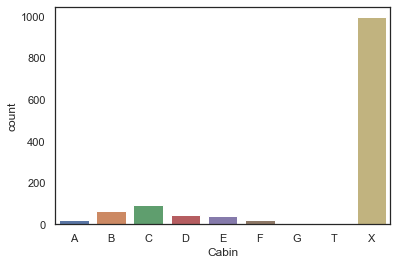

In [81]:
g = sns.countplot(df['Cabin'],order=['A','B','C','D','E','F','G','T','X'])

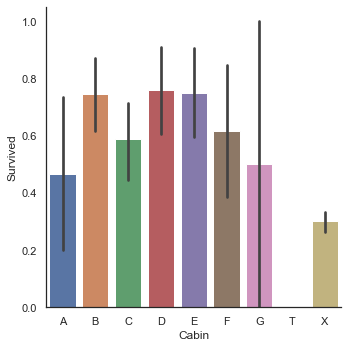

In [83]:
g = sns.catplot(x='Cabin',y='Survived',kind='bar',data=df,order=['A','B','C','D','E','F','G','T','X'])

Because of the low number of passengers that have a cabin, survival probabilities have an important standard deviation and we can't distinguish between survival probability of passengers in different desks/cabins.

But what can be clearly seen is that passengers with a cabin have more chance to survive than without which is X.

Particularly true for B,C,D,E, and F.

In [84]:
df = pd.get_dummies(df,columns=['Cabin'],prefix='Cabin')

#### Ticket

In [85]:
df['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

Tickets sharing the same prefixes could be booked for cabins that are placed together.

So tickets might be indicator of the actual placements of cabins in the ship.

So ticket number is not that significant, we can replace ticket feature with just the ticket prefix which will be more informative.

Another thing to assume here is that tickets with similar prefix will have similar class and survival rate.


In [86]:
# Treat ticket by extracting the prefix, when there is no prefix replace with X


Ticket = []

for i in list(df.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.','').replace('/','').strip().split(' ')[0])
    else:
        Ticket.append('X')
        
df['Ticket'] = Ticket

In [66]:
df.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Fsize,...,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,22.0,1.981001,0,1,3,0,1,0.0,A5,2,...,1,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,2,1,1,1,1.0,PC,2,...,0,0,0,1,0,0,0,0,0,0
2,26.0,2.070022,0,3,3,1,0,1.0,STONO2,1,...,1,0,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,4,1,1,1,1.0,X,2,...,1,0,0,1,0,0,0,0,0,0
4,35.0,2.085672,0,5,3,0,0,0.0,X,1,...,1,0,0,0,0,0,0,0,0,1


In [87]:
df = pd.get_dummies(df,columns=['Ticket'],prefix='T')

In [68]:
df.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Fsize,Single,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
0,22.0,1.981001,0,1,3,0,1,0.0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,4.266662,0,2,1,1,1,1.0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,26.0,2.070022,0,3,3,1,0,1.0,1,1,...,0,0,0,0,1,0,0,0,0,0
3,35.0,3.972177,0,4,1,1,1,1.0,2,0,...,0,0,0,0,0,0,0,0,0,1
4,35.0,2.085672,0,5,3,0,0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,1


In [88]:
# Create categorical values for Pclass

df['Pclass'] = df['Pclass'].astype('category')
df = pd.get_dummies(df,columns=['Pclass'],prefix='pc')

In [89]:
df.drop(labels=['PassengerId'],axis=1,inplace=True)

In [90]:
df.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MediumF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,pc_1,pc_2,pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## Modeling

In [91]:
# Separate out train and test datasets

train = df[:train_len]
test = df[train_len:]

In [92]:
test.drop(['Survived'],axis=1,inplace=True)

C:\Users\ASUS\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [93]:
# Split training data into features and target variables

train['Survived'] = train['Survived'].astype(int)

y_train = train['Survived']

X_train = train.drop('Survived',axis=1)

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Simple Modeling

#### Cross Validate Models

We'll use 10 classifiers and evaluate the mean accuracy of each of them by stratified kfold cross validation procedure.

* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* MLP - Multilayer Perceptron - Neural Network using SKlearn
* KNN
* Logistic Regression
* Linear Discriminant Analysis

In [94]:
# Cross validate model with K-fold stratified cross val

kfold = StratifiedKFold(n_splits=10)

In [95]:
random_state = 2
classifiers = []

classifiers.append(SVC(random_state=random_state))

classifiers.append(DecisionTreeClassifier(random_state=random_state))

classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                      random_state=random_state,learning_rate=0.1))

classifiers.append(RandomForestClassifier(random_state=random_state))

classifiers.append(ExtraTreesClassifier(random_state=random_state))

classifiers.append(GradientBoostingClassifier(random_state=random_state))

classifiers.append(MLPClassifier(random_state=random_state))

classifiers.append(KNeighborsClassifier())

classifiers.append(LogisticRegression(random_state=random_state))

classifiers.append(LinearDiscriminantAnalysis())

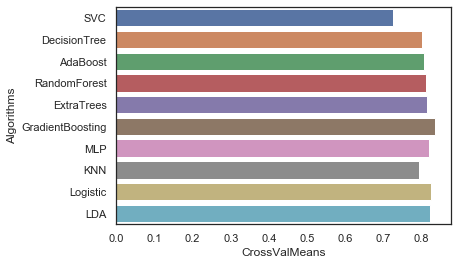

In [96]:
cv_results = []

for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,X_train,y=y_train,scoring='accuracy',cv=kfold,n_jobs=4))
    
cv_means = []
cv_std = []

#print(len(cv_means))
#print(len(cv_std))

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_results = pd.DataFrame({'CrossValMeans':cv_means,'CrossValErrors':cv_std,
                           'Algorithms':['SVC','DecisionTree','AdaBoost','RandomForest','ExtraTrees',
                                         'GradientBoosting','MLP','KNN','Logistic','LDA']})

g = sns.barplot('CrossValMeans','Algorithms',data=cv_results)

SVC, AdaBoost, RandomForest, ExtraTrees, and GBM for ensemble modeling.

#### Hyperparameter Tuning for best models


* Perform GridSearch Optimization

In [97]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC,random_state=7)

ada_param_grid = {'base_estimator__splitter':['best','random'],
                 'n_estimators':[1,2],
                 'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid=ada_param_grid,cv=kfold,scoring='accuracy',n_jobs=1,verbose=1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.1s finished


In [98]:
gsadaDTC.best_score_

0.8186650992685476

In [99]:
# Extra Trees

excx = ExtraTreesClassifier()

ex_param_grid = {'max_depth':[None],
                'max_features':[1,3,10],
                'min_samples_split':[2,3,10],
                'min_samples_leaf':[1,3,10],
                'bootstrap':[False],
                'n_estimators':[100,300],
                'criterion':['gini']}

gsexc = GridSearchCV(excx,param_grid=ex_param_grid,cv=kfold,scoring='accuracy',n_jobs=4,verbose=1)


gsexc.fit(X_train,y_train)


ex_best = gsexc.best_estimator_

gsexc.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.5min finished


0.8289968652037617

In [100]:
# Random Forest

rf = RandomForestClassifier()

rf_param_grid = {'max_depth':[None],
                'max_features':[1,3,10],
                'min_samples_split':[2,3,10],
                'min_samples_leaf':[1,3,10],
                'bootstrap':[False],
                'n_estimators':[100,300],
                'criterion':['gini']}

gsrfc = GridSearchCV(rf,param_grid=rf_param_grid,cv=kfold,scoring='accuracy',n_jobs=1,verbose=1)


gsrfc.fit(X_train,y_train)


rf_best = gsrfc.best_estimator_

gsrfc.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  5.4min finished


0.8289968652037617

In [103]:
# Gradient Boosting

gb = GradientBoostingClassifier()

gb_param_grid = {'loss':['deviance'],
                'n_estimators':[100,200,300],
                'learning_rate':[0.1,0.05,0.01],
                'max_depth':[4,8],
                'min_samples_leaf':[100,500],
                'max_features':[0.3,0.1]}

gsgbc = GridSearchCV(gb,param_grid=gb_param_grid,cv=kfold,scoring='accuracy',n_jobs=1,verbose=1)


gsgbc.fit(X_train,y_train)


gb_best = gsgbc.best_estimator_

gsgbc.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  2.7min finished


0.8254832810867294

In [104]:
svc = SVC(probability=True)

svc_param_grid = {'kernel':['rbf'],
                 'gamma':[0.001,0.01,0.1,1],
                 'C':[1,10,50,100,200,300,1000]}

gssvc = GridSearchCV(svc,param_grid=svc_param_grid,cv=kfold,scoring='accuracy',n_jobs=4,verbose=1)

gssvc.fit(X_train,y_train)

svc_best = gssvc.best_estimator_

gssvc.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   34.6s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   56.1s finished


0.831230407523511

# Plot Learning Curves - 

#### Checking feature importances


In order to see most informative features for prediction of passenger survival rates, displaying feature importance of tree based classifiers

nrows = ncols =2

fig,axes = plt.subplots(nrows=nrows,ncols=ncols,sharex='all',figsize=(15,15))

names_classifiers = [('Adaboost',ada_best),('ExtraTrees',ex_best),('RandomForest',rf_best),('GradientBoosting',gb_best)]

nclassifier = 0

for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        
        g = sns.barplot(y=X_train.columns[indices][:40],x=classifier.feature_importances_[indices][:40],orient='h',
                       ax=axes[row][col])
        nclassifier += 1




We plotted feature importance for 4 tree based classifiers.

* All the four classifiers have different top features. Although their accuracy score is around 83% but their prediction is not based on the same features.

# Homework - Read the plots and write down your inference of the plots above

#### Ensemble Modelling

Combining Models based on voting classifier for the predictions coming from 5 classifiers.

In [105]:
votingC = VotingClassifier(estimators=[('rfc',rf_best),('extc',ex_best),('svc',svc_best),('adac',ada_best),
                                      ('gbc',gb_best)],voting='soft',n_jobs=4)

votingC = votingC.fit(X_train,y_train)

#### Prediction

In [106]:
test_survived = pd.Series(votingC.predict(test),name='Survived')

In [107]:
results = pd.concat([IDtest,test_survived],axis=1)

In [108]:
results.to_csv('ensemble_voting_submission.csv',index=False)

# Done By Sairam Tadepalli